# TUGAS 12
Cetta Maulana A<br>
1103213119<br>
CNN Modern<br>
ResNet<br>
CIFAR10<br>
[ChatGPT](https://chatgpt.com/share/f398d823-086f-4a13-9008-017cc739172c)

In [1]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2024-06-19 15:36:05.446685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
for i in range(1,6):
    path = 'data_batch_' + str(i)
    with open(path, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    if i == 1:  
        x_train = (batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)).astype('float32')
        y_train = batch['labels']
    else:
        x_train_temp = (batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)).astype('float32')
        y_train_temp = batch['labels']
        x_train = np.concatenate((x_train,x_train_temp),axis = 0)
        y_train = np.concatenate((y_train,y_train_temp),axis=0)

path = 'test_batch'
with open(path,'rb') as file:
    # note the encoding type is 'latin1'
    batch = pickle.load(file, encoding='latin1')
    x_test = (batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)).astype('float32')
    y_test = batch['labels']

x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
y_train, y_test = tf.keras.utils.to_categorical(y_train, 10), tf.keras.utils.to_categorical(y_test, 10)


In [3]:
# Define a Residual Block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # First Convolutional Layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Convolutional Layer
    x = Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut if necessary
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', kernel_initializer='he_normal')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Define the ResNet model
def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Stacking Residual Blocks
    num_blocks = [2, 2, 2]
    filters = 64

    for stack in range(3):
        for block in range(num_blocks[stack]):
            if stack != 0 and block == 0:
                x = residual_block(x, filters, stride=2)
            else:
                x = residual_block(x, filters, stride=1)
        filters *= 2

    # Global Average Pooling and Output Layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

    model = Model(inputs, outputs)
    return model

# Build and compile the ResNet model
model = build_resnet(input_shape=(32, 32, 3), num_classes=10)

2024-06-19 15:36:15.084128: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 15:36:15.155063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 15:36:15.155118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 15:36:15.158183: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-19 15:36:15.158228: I external/local_xla/xla/stream_executor

In [4]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat

 Total params: 2,784,394 (10.62 MB)

 Trainable params: 2,779,914 (10.60 MB)

 Non-trainable params: 4,480 (17.50 KB)

In [5]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test,y_test), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

2024-06-19 15:36:27.352533: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2024-06-19 15:36:41.892298: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/100


I0000 00:00:1718811412.575874    6857 service.cc:145] XLA service 0x7efc64002b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718811412.576024    6857 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-19 15:36:52.944005: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-19 15:36:54.459349: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  1/782 ━━━━━━━━━━━━━━━━━━━━ 4:16:33 20s/step - accuracy: 0.1562 - loss: 2.9801

I0000 00:00:1718811423.072478    6857 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4767 - loss: 1.4522

2024-06-19 15:37:33.446805: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.
2024-06-19 15:37:33.514791: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.4768 - loss: 1.4519 - val_accuracy: 0.5879 - val_loss: 1.2374
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7287 - loss: 0.7697 - val_accuracy: 0.7341 - val_loss: 0.7699
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8008 - loss: 0.5716 - val_accuracy: 0.7121 - val_loss: 0.8611
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8472 - loss: 0.4435 - val_accuracy: 0.7352 - val_loss: 0.8242
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8873 - loss: 0.3310 - val_accuracy: 0.7671 - val_loss: 0.7539
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9115 - loss: 0.2535 - val_accuracy: 0.7261 - val_loss: 1.1178
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9360 - loss: 0.1838 - val_accuracy: 0.8069 - val_loss: 0.6721
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.9545 - loss: 0.1324 - val_

2024-06-19 15:44:29.812222: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 122880000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8076 - loss: 0.6650
Test accuracy: 0.8069000244140625


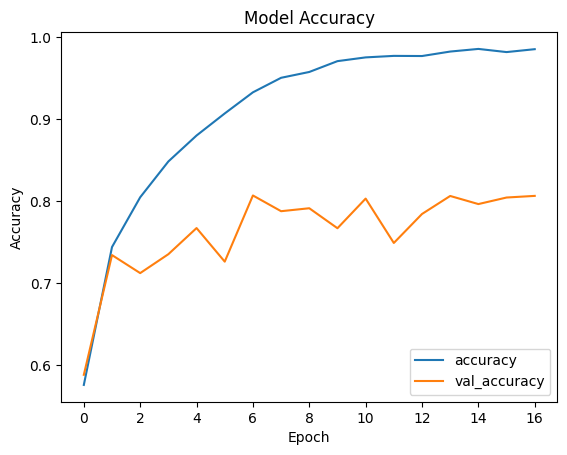

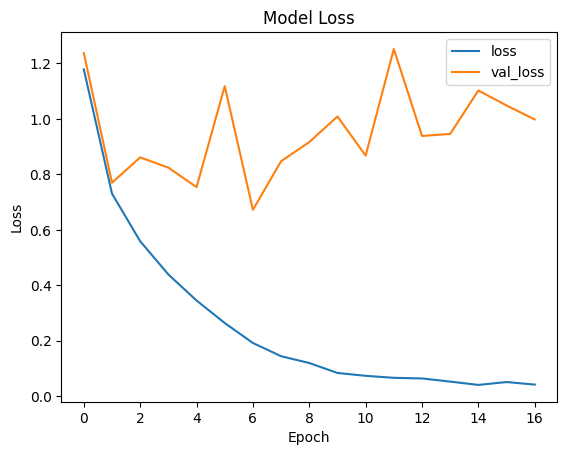

In [6]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()